In [23]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [24]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP) #cuantos cuadros hay

2000

In [25]:
DatosCMP[1337]

7×3 Array{Float64,2}:
  4.15995  25.0991    2493.22
 43.9996   46.0026    3347.96
  2.99887  11.9951    3355.06
  7.00194  19.9985    3346.89
  1.46749  21.602    11805.0 
 59.8803    8.20336  31117.2 
  1.0      16.5164    3172.54

In [26]:
DatosCMP[1341]

7×3 Array{Float64,2}:
  4.16123  25.0985    2507.9 
 44.0012   45.9989    3367.17
  2.99954  11.9971    3342.16
  7.00254  19.9977    3364.37
  1.46772  21.6013   11819.3 
 59.881     8.20467  31142.7 
  1.0      16.5191    3178.63

In [27]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

Para Evocados, hay un par de variables temporales para considerar:
- retrazo: el tiempo en cuadros que hubo desde el comienzo del registro hasta el estimulo
- latencia: el tiempo en cuadros que hubo desde el estimulo hasta que paso algo interesante


In [28]:
freq=7.022 # la frecuencia de muestreo en kHz de los experimentos viejos

if evocada
    retms=5.0 #retrazo en milisec
    latms=4.0 #latencia en milisec
    retrazo=round(Int, retms * freq)
    lat=round(Int, latms * freq)
    desde=retrazo+lat
    hasta=300
else
    retms=0
    latms=0
    retrazo=0
    lat=0
    desde=1
    hasta=nmax
end

2000

In [29]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [30]:
difgordis(0.21,0.29)

0.27586206896551724

In [31]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1

Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [32]:
(desde, hasta)


(1, 2000)

In [33]:
pesomin=1
longmin=3

3

In [34]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,longmin,pesomin,desde,hasta);


  0.482016 seconds (1.54 M allocations: 469.388 MiB, 12.95% gc time)


In [35]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,longmin,pesomin,desde,hasta);

In [13]:
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
nota="longitud minima fue $longmin, peso minimo fue $pesomin "
#save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo, "nota", nota)

"longitud minima fue 3, peso minimo fue 1 "

In [36]:
length(CatenarioPositivo), length(CatenarioNegativo)

(10, 8)

In [37]:
CatenarioPositivo

Dict{Integer,Array{Any,N} where N} with 10 entries:
  7  => Any[59.7881 7.57328 35259.6 1.0; 59.7885 7.57326 35311.4 2.0; … ; 59.88…
  4  => Any[4.16028 25.0959 2494.4 1.0; 4.16039 25.0962 2492.41 2.0; … ; 4.1601…
  9  => Any[3.0015 53.0016 3356.45 1.0; 3.00201 53.0004 3350.91 2.0; … ; 2.9955…
  10 => Any[43.9998 45.8562 602.59 610.0; 44.002 45.9971 1327.76 611.0; … ; 44.…
  2  => Any[1.46762 21.6023 11812.7 1.0; 1.46759 21.6024 11819.2 2.0; … ; 1.467…
  3  => Any[42.9959 5.0023 3339.76 1.0; 42.9963 5.00143 3346.84 2.0; … ; 42.997…
  5  => Any[1.0 16.5139 3180.4 1.0; 1.0 16.517 3179.26 2.0; … ; 1.0 16.5182 317…
  8  => Any[7.00581 20.0028 3341.45 1.0; 7.00583 20.0026 3348.85 2.0; … ; 7.003…
  6  => Any[2.99981 11.9946 3336.78 1.0; 2.99937 11.996 3343.91 2.0; … ; 3.0024…
  1  => Any[21.0005 36.9927 3364.2 1.0; 20.9993 36.9946 3356.83 2.0; … ; 20.995…

In [15]:
nombreout

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-Tray-todas.jld"

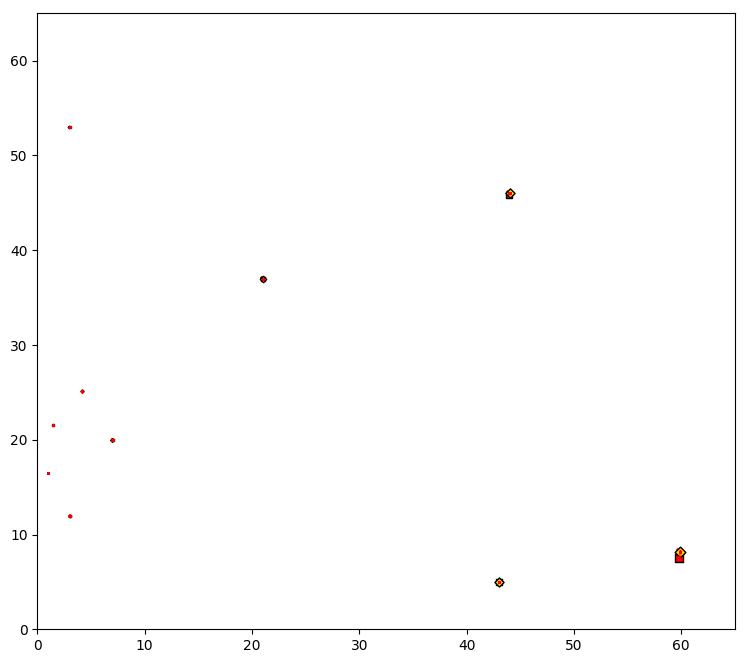

In [39]:
#PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=0
minlong=0
maxlong=20000
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r", lw=0.25, zorder=15)
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" ,
        zorder=1)
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final", zorder=2 )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [54]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 860 entries. Values:
  Any[31.5812 29.3239 -203.75 663.0; 32.0047 30.0982 -229.158 664.0; 32.4171 31…
  Any[17.7235 61.011 -263.295 214.0; 17.4776 60.757 -362.718 215.0; … ; 17.7665…
  Any[55.4341 47.3057 -2524.4 448.0; 55.2756 47.1163 -2450.98 449.0; 55.5759 46…
  Any[40.4962 31.4264 -136.71 546.0; 39.2454 31.8379 -182.66 547.0; 39.0034 31.…
  Any[27.4338 60.4188 -365.09 643.0; 26.7776 60.2849 -260.412 644.0; 26.5807 60…
  Any[35.8058 29.6784 -586.528 675.0; 36.9603 29.8958 -627.706 676.0; … ; 39.40…
  Any[23.278 61.5997 -341.025 710.0; 23.3864 61.4841 -375.122 711.0; 23.172 61.…
  Any[39.8889 58.7892 -191.545 999.0; 39.8666 58.306 -317.436 1000.0; 39.7325 5…
  Any[49.3629 55.7831 -202.636 941.0; 48.8359 56.2677 -257.566 942.0; … ; 50.56…
  Any[60.7451 45.4388 -121.94 1078.0; 60.1197 46.1888 -189.813 1079.0; … ; 59.3…
  Any[35.5023 31.4859 -91.6817 1155.0; 35.596 31.5039 -124.504 1156.0; 36.4779 …
  Any[48.9318 54.112 -3